# 1-1,结构化数据建模流程范例

### 一，准备数据

titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


![](./data/1-1-数据集展示.jpg)

字段说明：

* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】


利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

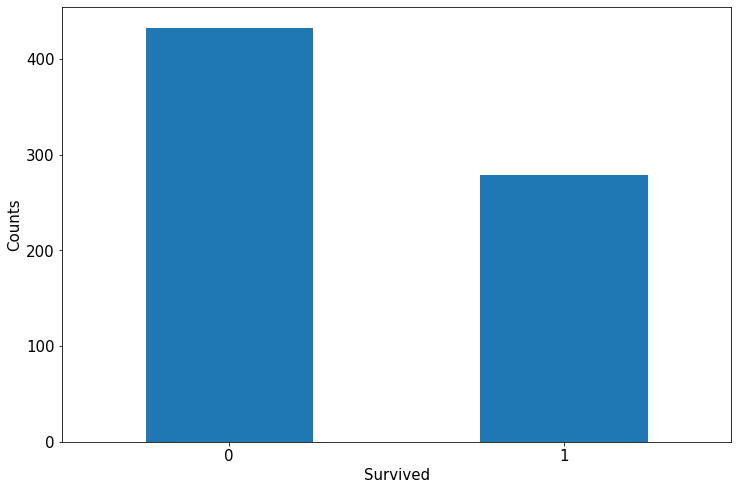

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
plt.ylabel('Counts',fontsize = 15)
plt.xlabel('Survived',fontsize = 15)
plt.show()

年龄分布情况

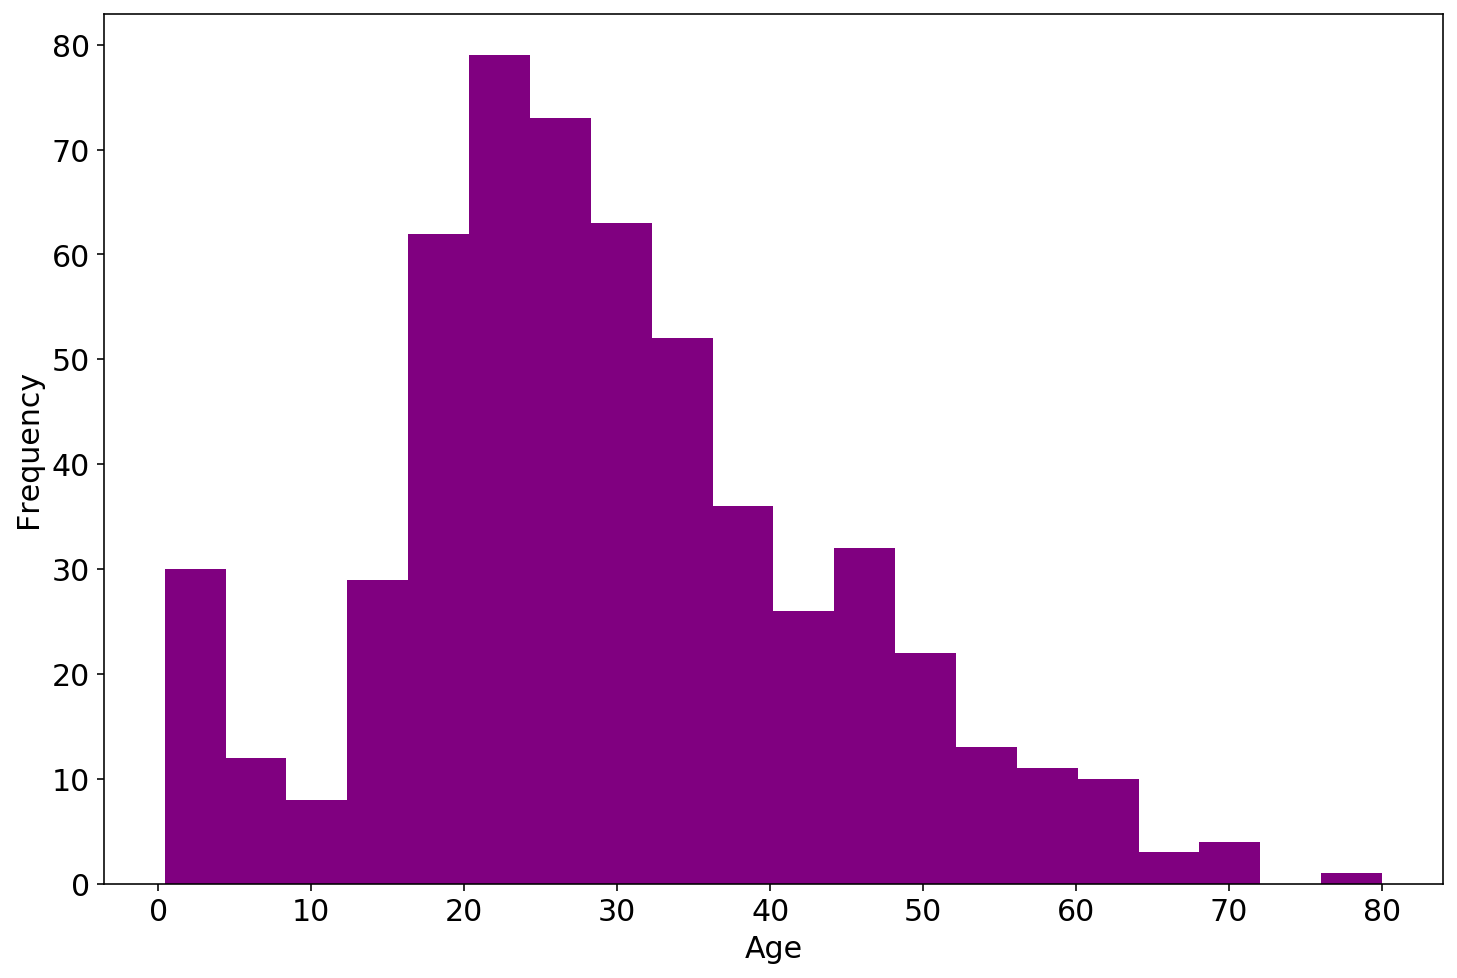

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

plt.ylabel('Frequency',fontsize = 15)
plt.xlabel('Age',fontsize = 15)
plt.show()

年龄和label的相关性

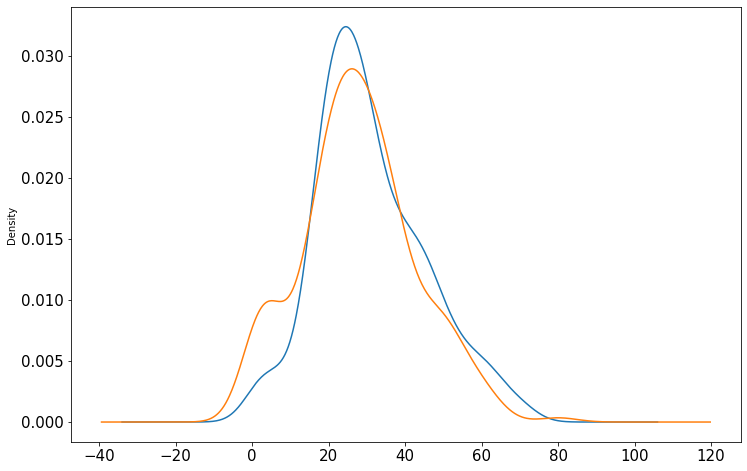

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',#query使用bool表达式查询，性能教python语法佳
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12,)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

下面为正式的数据预处理

In [20]:
def preprocessing(dfdata):
#     将每一列做相应的特征转化


    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])# get_dummies 是利用pandas实现one hot encode的方式
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = dfPclass

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print(x_train.shape, x_test.shape )


(712, 15) (179, 15)


### 二，定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [ ]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
=================================================================
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
```

### 三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [ ]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )

```
Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 1s 2ms/sample - loss: 3.5841 - AUC: 0.4079 - val_loss: 3.4429 - val_AUC: 0.4129
Epoch 2/30
569/569 [==============================] - 0s 102us/sample - loss: 2.6093 - AUC: 0.3967 - val_loss: 2.4886 - val_AUC: 0.4139
Epoch 3/30
569/569 [==============================] - 0s 68us/sample - loss: 1.8375 - AUC: 0.4003 - val_loss: 1.7383 - val_AUC: 0.4223
Epoch 4/30
569/569 [==============================] - 0s 83us/sample - loss: 1.2545 - AUC: 0.4390 - val_loss: 1.1936 - val_AUC: 0.4765
Epoch 5/30
569/569 [==============================] - ETA: 0s - loss: 1.4435 - AUC: 0.375 - 0s 90us/sample - loss: 0.9141 - AUC: 0.5192 - val_loss: 0.8274 - val_AUC: 0.5584
Epoch 6/30
569/569 [==============================] - 0s 110us/sample - loss: 0.7052 - AUC: 0.6290 - val_loss: 0.6596 - val_AUC: 0.6880
Epoch 7/30
569/569 [==============================] - 0s 90us/sample - loss: 0.6410 - AUC: 0.7086 - val_loss: 0.6519 - val_AUC: 0.6845
Epoch 8/30
569/569 [==============================] - 0s 93us/sample - loss: 0.6246 - AUC: 0.7080 - val_loss: 0.6480 - val_AUC: 0.6846
Epoch 9/30
569/569 [==============================] - 0s 73us/sample - loss: 0.6088 - AUC: 0.7113 - val_loss: 0.6497 - val_AUC: 0.6838
Epoch 10/30
569/569 [==============================] - 0s 79us/sample - loss: 0.6051 - AUC: 0.7117 - val_loss: 0.6454 - val_AUC: 0.6873
Epoch 11/30
569/569 [==============================] - 0s 96us/sample - loss: 0.5972 - AUC: 0.7218 - val_loss: 0.6369 - val_AUC: 0.6888
Epoch 12/30
569/569 [==============================] - 0s 92us/sample - loss: 0.5918 - AUC: 0.7294 - val_loss: 0.6330 - val_AUC: 0.6908
Epoch 13/30
569/569 [==============================] - 0s 75us/sample - loss: 0.5864 - AUC: 0.7363 - val_loss: 0.6281 - val_AUC: 0.6948
Epoch 14/30
569/569 [==============================] - 0s 104us/sample - loss: 0.5832 - AUC: 0.7426 - val_loss: 0.6240 - val_AUC: 0.7030
Epoch 15/30
569/569 [==============================] - 0s 74us/sample - loss: 0.5777 - AUC: 0.7507 - val_loss: 0.6200 - val_AUC: 0.7066
Epoch 16/30
569/569 [==============================] - 0s 79us/sample - loss: 0.5726 - AUC: 0.7569 - val_loss: 0.6155 - val_AUC: 0.7132
Epoch 17/30
569/569 [==============================] - 0s 99us/sample - loss: 0.5674 - AUC: 0.7643 - val_loss: 0.6070 - val_AUC: 0.7255
Epoch 18/30
569/569 [==============================] - 0s 97us/sample - loss: 0.5631 - AUC: 0.7721 - val_loss: 0.6061 - val_AUC: 0.7305
Epoch 19/30
569/569 [==============================] - 0s 73us/sample - loss: 0.5580 - AUC: 0.7792 - val_loss: 0.6027 - val_AUC: 0.7332
Epoch 20/30
569/569 [==============================] - 0s 85us/sample - loss: 0.5533 - AUC: 0.7861 - val_loss: 0.5997 - val_AUC: 0.7366
Epoch 21/30
569/569 [==============================] - 0s 87us/sample - loss: 0.5497 - AUC: 0.7926 - val_loss: 0.5961 - val_AUC: 0.7433
Epoch 22/30
569/569 [==============================] - 0s 101us/sample - loss: 0.5454 - AUC: 0.7987 - val_loss: 0.5943 - val_AUC: 0.7438
Epoch 23/30
569/569 [==============================] - 0s 100us/sample - loss: 0.5398 - AUC: 0.8057 - val_loss: 0.5926 - val_AUC: 0.7492
Epoch 24/30
569/569 [==============================] - 0s 79us/sample - loss: 0.5328 - AUC: 0.8122 - val_loss: 0.5912 - val_AUC: 0.7493
Epoch 25/30
569/569 [==============================] - 0s 86us/sample - loss: 0.5283 - AUC: 0.8147 - val_loss: 0.5902 - val_AUC: 0.7509
Epoch 26/30
569/569 [==============================] - 0s 67us/sample - loss: 0.5246 - AUC: 0.8196 - val_loss: 0.5845 - val_AUC: 0.7552
Epoch 27/30
569/569 [==============================] - 0s 72us/sample - loss: 0.5205 - AUC: 0.8271 - val_loss: 0.5837 - val_AUC: 0.7584
Epoch 28/30
569/569 [==============================] - 0s 74us/sample - loss: 0.5144 - AUC: 0.8302 - val_loss: 0.5848 - val_AUC: 0.7561
Epoch 29/30
569/569 [==============================] - 0s 77us/sample - loss: 0.5099 - AUC: 0.8326 - val_loss: 0.5809 - val_AUC: 0.7583
Epoch 30/30
569/569 [==============================] - 0s 80us/sample - loss: 0.5071 - AUC: 0.8349 - val_loss: 0.5816 - val_AUC: 0.7605

```

### 四，评估模型

我们首先评估一下模型在训练集和验证集上的效果。

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(history,"loss")

![](./data/1-1-Loss曲线.jpg)

In [ ]:
plot_metric(history,"AUC")

![](./data/1-1-AUC曲线.jpg)

我们再看一下模型在测试集上的效果.

In [ ]:
model.evaluate(x = x_test,y = y_test)

```
[0.5191367897907448, 0.8122605]
```

### 五，使用模型

In [ ]:
#预测概率
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #等价写法

```
array([[0.26501188],
       [0.40970832],
       [0.44285864],
       [0.78408605],
       [0.47650957],
       [0.43849158],
       [0.27426785],
       [0.5962582 ],
       [0.59476686],
       [0.17882936]], dtype=float32)
```

In [ ]:
#预测类别
model.predict_classes(x_test[0:10])

```
array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]], dtype=int32)
```

### 六，保存模型

可以使用Keras方式保存模型，也可以使用TensorFlow原生方式保存。前者仅仅适合使用Python环境恢复模型，后者则可以跨平台进行模型部署。

推荐使用后一种方式进行保存。

**1，Keras方式保存**

In [ ]:
# 保存模型结构及权重

model.save('./data/keras_model.h5')  

del model  #删除现有模型

# identical to the previous one
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test,y_test)

```
[0.5191367897907448, 0.8122605]
```

In [ ]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

In [ ]:
#保存模型权重
model.save_weights('./data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# 加载权重
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

```
[0.5191367897907448, 0.8122605]
```

**2，TensorFlow原生方式保存**

In [ ]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [ ]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

```
[0.5191365896656527, 0.8122605]
```

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"Python与算法之美"下留言。作者时间和精力有限，会酌情予以回复。

![image.png](./data/Python与算法之美logo.jpg)